# Cisco - Ariel University API Security Detection Challenge 2023

## Student ID: 207276775
GitHub project: https://github.com/RazElbaz/API_security_challenge

The site that helped me find algorithms:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=ubWnuAa4wIHnDTz0Su8AYWJAM7fUMCps6AxyNzFok...,"Fri, 11 Nov 2022 02:57:49 GMT",GET,http://127.0.0.1:5000/orders/get/employee_id/5482,,404 NOT FOUND,application/json,39,404,"{""error"": ""Employee ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
127496,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=SkLWkaUE83sP38c3kf-XYBCKlSlSmBTQSEJw6EaMg...,"Fri, 11 Nov 2022 02:56:21 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127497,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=giYaDJkC2Oa-rCmlAvYglQzy_Em-YHTv_5aOjposX...,"Fri, 11 Nov 2022 02:49:37 GMT",GET,http://127.0.0.1:5000/post/new/,,200 OK,text/html; charset=utf-8,70,200,<form method='POST'><input name='message'><inp...,NaN,NaN,NaN,NaN,Benign,Benign
127498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=VzOU9Ac91LxJ8UAvQ8Wt3c5Ua-30j4s9kcdTKrwCw...,"Fri,

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",None,None,None,None,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",None,None,None,None,Benign,Benign


In [4]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0,-0.755929,0,0,0,1,0,0,0,0,-0.646997,0,0.408248,4,-1.0,404,0.408248,-1.0,-1.0,-1.0,-1.0,Benign,Benign
1,0,0.000000,0,0,0,3,0,0,0,0,-0.480384,0,0.000000,0,-1.0,200,0.956183,-1.0,-1.0,-1.0,-1.0,Benign,Benign
2,0,-0.408248,0,0,0,1,0,1,0,0,0.426401,0,0.707107,0,-1.0,200,-0.255551,-1.0,-1.0,-1.0,-1.0,Benign,Benign
3,0,0.666667,0,0,0,2,0,0,0,0,-0.593391,0,0.577350,4,-1.0,404,0.408248,-1.0,-1.0,-1.0,-1.0,Benign,Benign
4,0,-0.471405,0,0,0,3,0,1,0,0,-0.652753,0,0.377964,4,-1.0,404,0.894427,-1.0,-1.0,-1.0,-1.0,Benign,Benign


In [5]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Host             127500 non-null  int32  
 1   request.headers.User-Agent       127500 non-null  float64
 2   request.headers.Accept-Encoding  127500 non-null  int32  
 3   request.headers.Accept           127500 non-null  int32  
 4   request.headers.Connection       127500 non-null  int32  
 5   request.headers.Accept-Language  127500 non-null  int32  
 6   request.headers.Sec-Fetch-Site   127500 non-null  int32  
 7   request.headers.Sec-Fetch-Mode   127500 non-null  int32  
 8   request.headers.Sec-Fetch-User   127500 non-null  int32  
 9   request.headers.Sec-Fetch-Dest   127500 non-null  int32  
 10  request.headers.Set-Cookie       127500 non-null  float64
 11  request.method                   127500 non-null  int32  
 12  re

In [6]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie']


request.headers.Host                 int32
request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.status_code                 int64
response.body                      float64
response.headers.Location          float64
request.headers.Cookie             float64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: obje

## Train test split

In [7]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(104996, 21) (104996,)
(22504, 21) (22504,)


Counter({'Benign': 117914,
         'Log Forging': 1181,
         'LOG4J': 1284,
         'Cookie Injection': 2396,
         'RCE': 1172,
         'Directory Traversal': 1270,
         'SQL Injection': 2283})

## Model choosing and fitting

## Result printout

In [8]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

### Model 1- RandomForestClassifier()

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]
                     precision    recall  f1-score   support

             Benign    0.98402   0.99145   0.98772     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    0.45050   0.40625   0.42723       224
              LOG4J    0.90400   0.49780   0.64205       227
        Log Forging    1.00000   1.00000   1.00000       208
                RCE    1.00000   1.00000   1.00000       207
      SQL Injection    0.85135   0.78164   0.81501       403

           accuracy                        0.97720     22504
          macro avg    0.88427   0.81102   0.83886     22504
       weighted avg    0.97613   0.97720   0.97602     22504



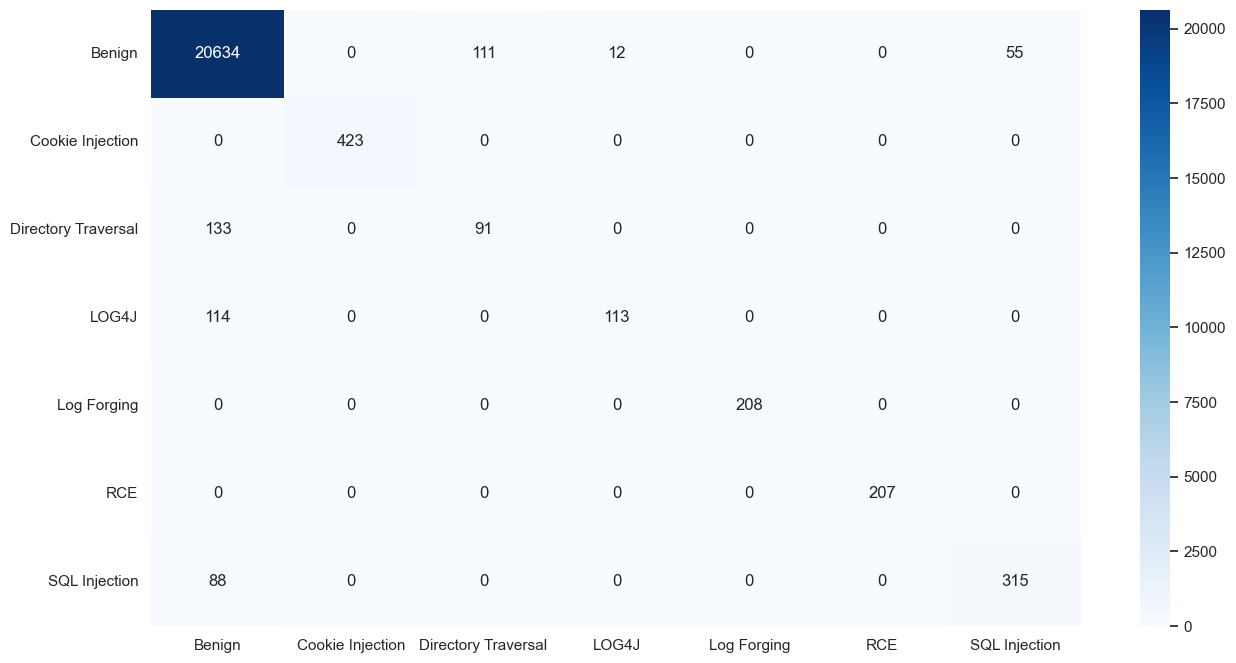

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier()

parameters = {"n_estimators": [100,200,300,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
clf = GridSearchCV(clf, parameters)
# Train Model
clf.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
clf = clf.best_estimator_
ResultPrintout(clf)

### Model 2- DecisionTreeClassifier()

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]


C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.96697   1.00000   0.98321     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    0.00000   0.00000   0.00000       224
              LOG4J    1.00000   0.44053   0.61162       227
        Log Forging    1.00000   1.00000   1.00000       208
                RCE    0.00000   0.00000   0.00000       207
      SQL Injection    1.00000   0.62035   0.76570       403

           accuracy                        0.96841     22504
          macro avg    0.70957   0.58013   0.62293     22504
       weighted avg    0.95030   0.96841   0.95720     22504



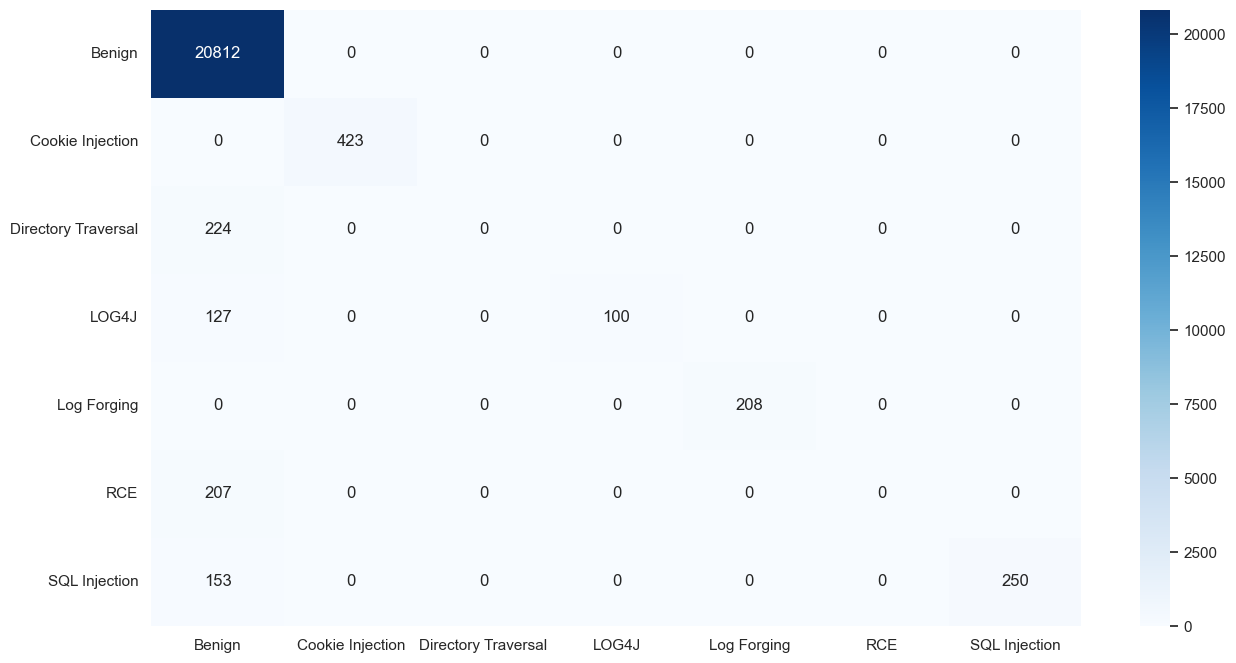

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier

# We choose our model of choice and set it's hyper parameters you can change anything
dtc = DecisionTreeClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"random_state": [None,10,20,30,40,50,100,200,300],
             "splitter":["best", "random"],
             "max_depth":[1,2,3,4,5,6,7,8,9,10]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
dtc = GridSearchCV(dtc, parameters)
# Train Model
dtc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
dtc = dtc.best_estimator_
ResultPrintout(dtc)

### Model 3- GradientBoostingClassifier()

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]
                     precision    recall  f1-score   support

             Benign    0.97824   0.99995   0.98897     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    1.00000   0.00893   0.01770       224
              LOG4J    1.00000   0.49780   0.66471       227
        Log Forging    1.00000   1.00000   1.00000       208
                RCE    1.00000   1.00000   1.00000       207
      SQL Injection    0.99639   0.68486   0.81176       403

           accuracy                        0.97938     22504
          macro avg    0.99638   0.74165   0.78331     22504
       weighted avg    0.97981   0.97938   0.97327     22504



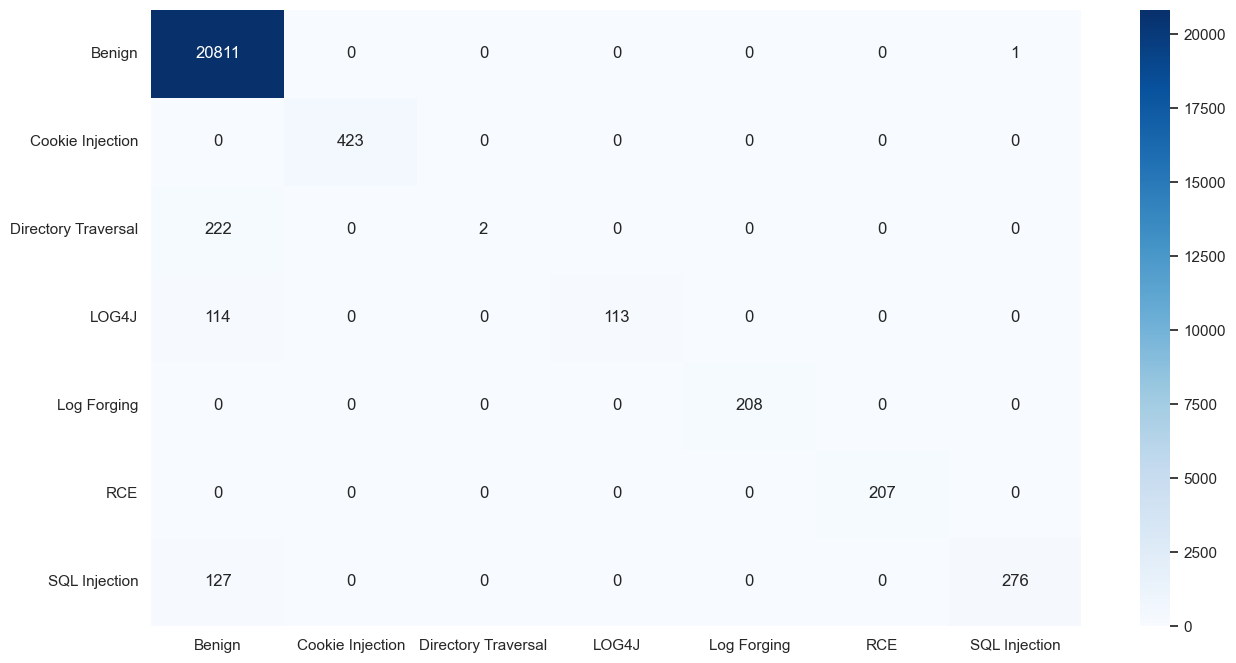

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
gbc = GradientBoostingClassifier()

parameters = {"n_estimators": [50,100,200,300,350,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
gbc = GridSearchCV(gbc, parameters)
# Train Model
gbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
gbc = gbc.best_estimator_
ResultPrintout(gbc)


### Model 4- AdaBoostClassifier()

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]


C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\97252\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.94253   1.00000   0.97041     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    0.00000   0.00000   0.00000       224
              LOG4J    0.00000   0.00000   0.00000       227
        Log Forging    0.00000   0.00000   0.00000       208
                RCE    0.00000   0.00000   0.00000       207
      SQL Injection    0.00000   0.00000   0.00000       403

           accuracy                        0.94361     22504
          macro avg    0.27750   0.28571   0.28149     22504
       weighted avg    0.89046   0.94361   0.91625     22504



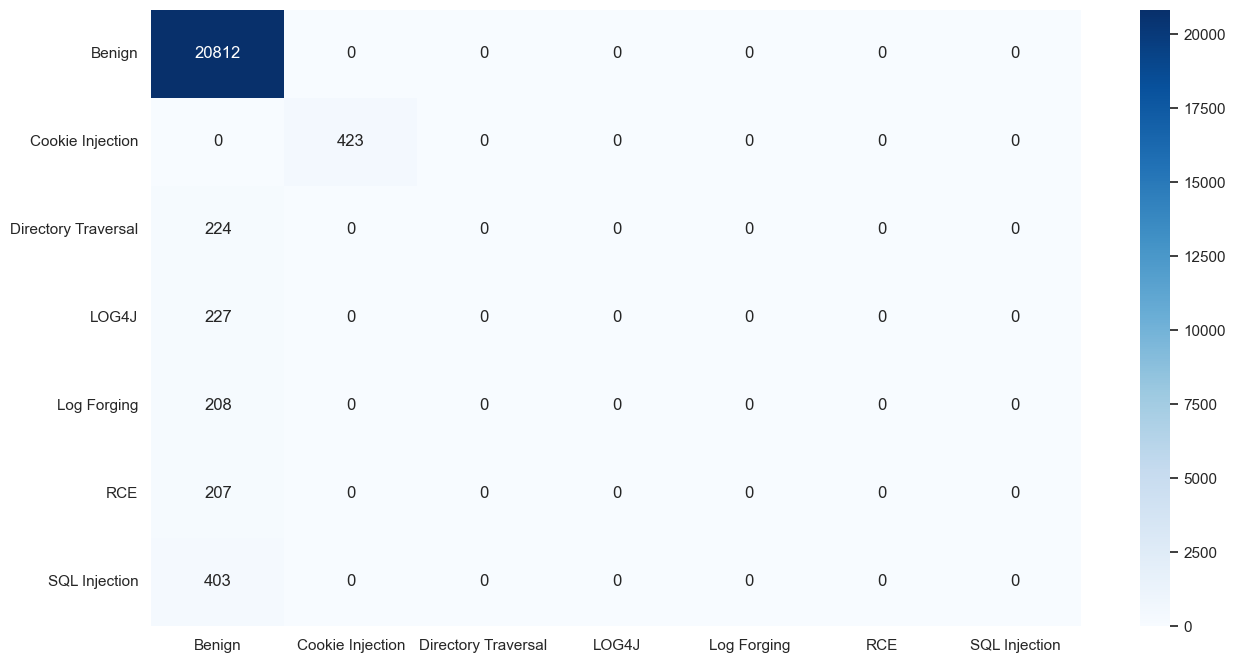

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
abc = AdaBoostClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"random_state": [None,10,20,30,40,50,100,200,300],
              "n_estimators": [50,100,200,300,400]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
abc = GridSearchCV(abc, parameters)
# Train Model
abc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
abc = abc.best_estimator_
ResultPrintout(abc)

### Model 5- ExtraTreesClassifier() 

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]
                     precision    recall  f1-score   support

             Benign    0.98268   0.99260   0.98762     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    0.46784   0.35714   0.40506       224
              LOG4J    0.89516   0.48899   0.63248       227
        Log Forging    1.00000   1.00000   1.00000       208
                RCE    1.00000   0.99517   0.99758       207
      SQL Injection    0.85714   0.74442   0.79681       403

           accuracy                        0.97698     22504
          macro avg    0.88612   0.79690   0.83136     22504
       weighted avg    0.97507   0.97698   0.97526     22504



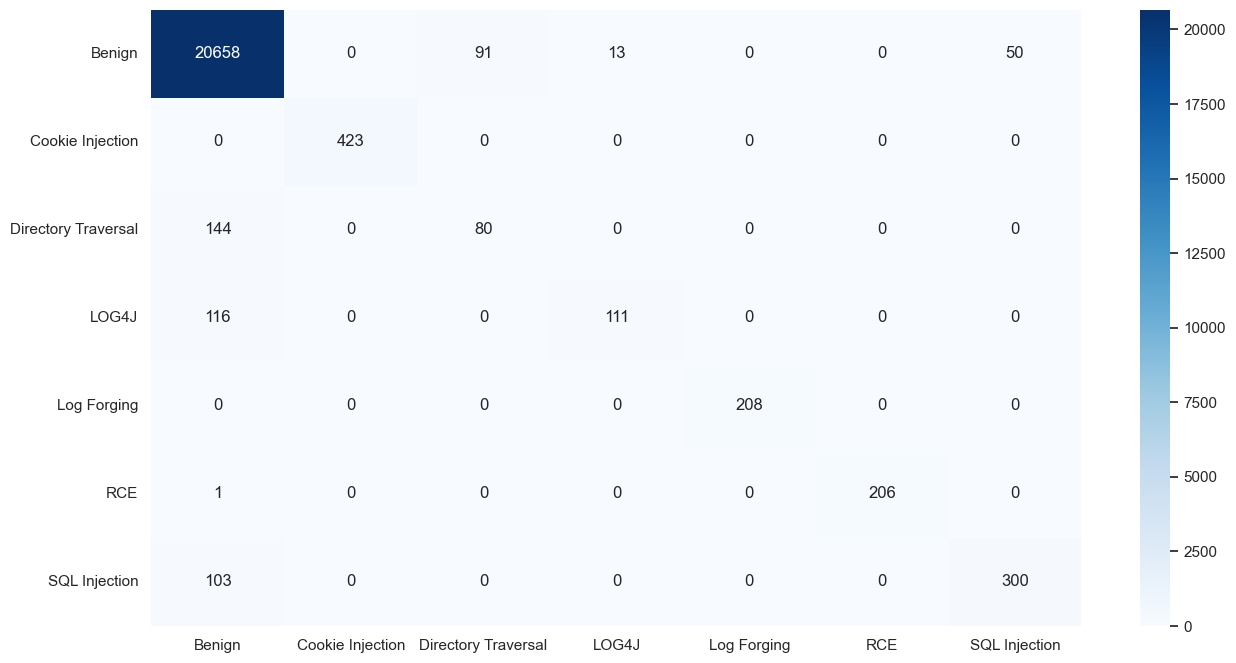

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
from sklearn.ensemble import ExtraTreesClassifier
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
# We choose our model of choice and set it's hyper parameters you can change anything
etc = ExtraTreesClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = { "n_estimators": [50,100,200,300,400],
              "min_samples_split":[2,3,4]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
etc = GridSearchCV(etc, parameters)
# Train Model
etc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
etc = etc.best_estimator_
ResultPrintout(etc)

### Model 6- HistGradientBoostingClassifier() 

[('Benign', 97102), ('Cookie Injection', 1973), ('Directory Traversal', 1046), ('LOG4J', 1057), ('Log Forging', 973), ('RCE', 965), ('SQL Injection', 1880)]
                     precision    recall  f1-score   support

             Benign    0.98372   0.99270   0.98819     20812
   Cookie Injection    1.00000   1.00000   1.00000       423
Directory Traversal    0.40678   0.32143   0.35910       224
              LOG4J    0.95763   0.49780   0.65507       227
        Log Forging    1.00000   1.00000   1.00000       208
                RCE    1.00000   1.00000   1.00000       207
      SQL Injection    0.87805   0.80397   0.83938       403

           accuracy                        0.97792     22504
          macro avg    0.88945   0.80227   0.83453     22504
       weighted avg    0.97642   0.97792   0.97634     22504



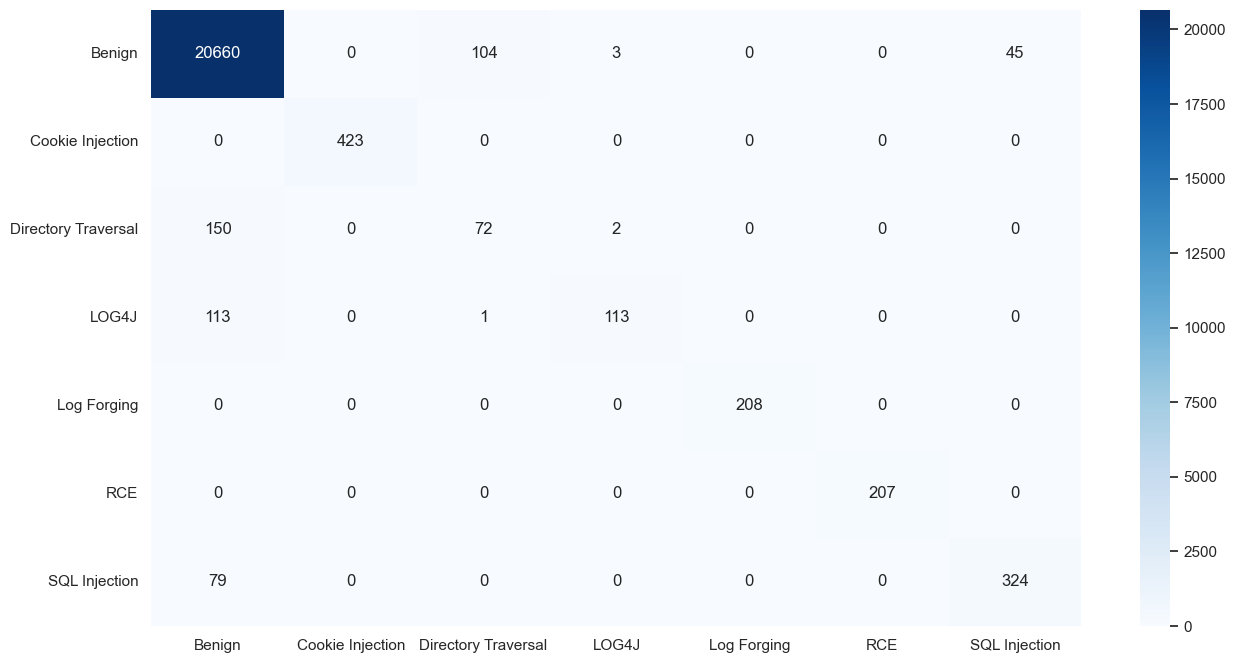

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import HistGradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
hgbc = HistGradientBoostingClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
              "max_iter":[20,50,100,200]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
hgbc = GridSearchCV(hgbc, parameters)
# Train Model
hgbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
hgbc = hgbc.best_estimator_
ResultPrintout(hgbc)

# Choosing the best model

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,dtc,gbc,abc,etc,hgbc}
for i in models:
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
print(best)
print(m)
    

97.9381443298969
GradientBoostingClassifier(n_estimators=50)


# Test

In [16]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = m.predict(X)
print(m)

GradientBoostingClassifier(n_estimators=50)


# Save your predictions

In [17]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')